# CellRank for time-series datasets
This tutorial demonstrates how to use CellRank's interface to [Waddington OT (WOT)](link) to work with time-series scRNA-seq data (see [Schiebinger et al., Cell 2019]() for the original publication). The interface is constructed via an [external kernel](link). In CellRank, we call everyting that computes a cell-cell transition matrix a kernel, see our [kernels and estimators tutorial](link). An external kernel wraps around another method (like Waddington OT) so that you can use it from within CellRank, through the usual API. If you have your own method that you would like to integrate as an external kernel in CellRank, see our [Creating a new kernel tutorial](link). 

We'll demonstrate this using the original data from the [WOT publication](), i.e. reprogramming of mouse embryonic fibroblasts (MEFs) towards induced pluripotent stem cells (iPSCs) across 38 time points spanning days 0-18 past reprogramming. We'll restrict our attention to the serum condition and subsample the data to speed up computations. 

## Import packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib import rcParams
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scvelo as scv
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

Import the data

In [3]:
adata = scv.read("../../../data/schiebinger_reprogramming/ML-2021-06-05_merged_data.h5ad")

This data contains cells cultured in both 2i as well as serum conditions - we'll focus on the serum condition here. 

In [4]:
adata = adata[adata.obs['serum'] == 'True'].copy()

Subsample to speed up the analysis - this tutorial is meant to run in a couple of minutes on a laptop. It's no problem to do any of the computations here on the full data, you'll just have to move to a server or wait a bit longer. 

In [5]:
sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 41473 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

Let's visualize this data, using the original force-directed layout as well as annotated cell sets. We simplifed the original cell-set annotations for our purposes here. 

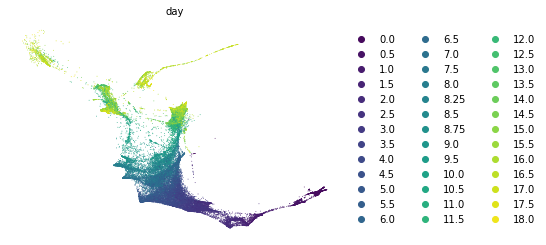

In [6]:
scv.pl.scatter(adata, basis='force_directed', c='day', legend_loc='right')

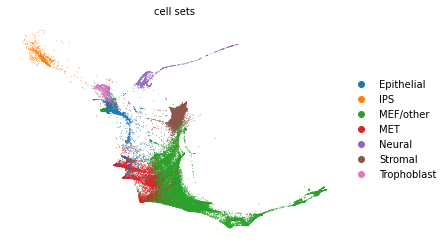

In [7]:
scv.pl.scatter(adata, basis='force_directed', c='cell_sets', legend_loc='right')

## Define utility functions

We'll need a few utility functions in this tutorial. 

In [51]:
from typing import Optional, TypeVar, Iterable, Tuple
AnnData = TypeVar("AnnData")

This one is a nice way to show what clusters/timepoints a macrostate is composed off. 

In [9]:
def stacked_histogram(adata: AnnData, 
                      states_key: str = 'macrostates', 
                      cat_key: str ='cluster',
                      width: float = 0.8, 
                      figsize: Iterable[float] = (5, 4),
                      show_title: bool = True,
                      rotation: int = 0,
                      save: Optional[str] = None):
    """Plot stacked histogram for macrostats over categorical annotations
    
    Parameters
    ---
    adata
        Annotated data matrix
    states_key
        Key from `.obs` where macrostate clustering can be found
    cat_key
        Key from `.obs` where the categorical annotations can be found
    width
        Bar width
    figsize
        Size of the overall figure
    show_title
        Whether to display generated titles
    rotation
        x-label rotation
    save
        Path where the figure is to be saved
        
    Returns
    ---
    Noting, just plots
    """
    
    # pull annotations from AnnData object
    mask = ~adata.obs[states_key].isna()
    base_df = sc.get.obs_df(adata[mask], [cat_key, states_key])
    
    # define parameters
    macrostates = list(base_df[states_key].cat.categories)
    cats = list(base_df[cat_key].cat.categories)
    cats_colors = adata.uns[f"{cat_key}_colors"]
    ind = np.arange(len(macrostates))
    y_max = np.array([np.sum(base_df[states_key] == ms) for ms in macrostates]).max()
    
    # initialise the figure
    fig = plt.figure(None, figsize)
    bottom = np.array([0] * len(macrostates))

    # iterate over categories, plot one barchart per category
    for i, cat in enumerate(cats):
        frequencies = [np.sum(base_df.loc[base_df[states_key] == ms, cat_key] == cat) for ms in macrostates]
        plt.bar(ind, frequencies, width, label=cat, color=cats_colors[i], bottom=bottom)
        bottom += np.array(frequencies)
    
    # prettify the plot
    plt.ylabel('frequency')
    plt.xlabel('macrostate')
    plt.xticks(ind, macrostates)
    plt.xticks(rotation=rotation)
    
    if show_title:
        plt.title(f"distribution over `{cat_key}`")
    plt.ylim([0, y_max + 2])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if save is not None:
        plt.savefig(save)
    plt.show()

This one can be used to visualize the distribution over fate probabilities across time-points. 

In [56]:
def plot_fate(adata: AnnData, 
              fate: str, 
              gene: Optional[str] = None, 
              threshold: float = 0, 
              title: str = "", 
              figsize: Tuple[int] = (10, 4),
              dpi=80):
    """Utility function to plot distribution of log-odds of `fate` vs. all
    
    Log-odds are plotted as a function of the experimental time-point. Optionally, gene 
    expression can be overlaid to check for genes that show early fate bias. 
    
    Parameters
    --------
    adata
        Annodated data matrix.
    fate
        Key from `adata.obsm['to_terminal_states'].names`.
    gene
        Key from `adata.var_names`.
    title
        Title of the plot.
    figsize
        Figure size
    dpi
        Figure resolution
        
    Returns
    -------
    Nothing, just plots. 
    """

    # define log-odds
    fate1 = adata.obsm['to_terminal_states'][fate].X
    fate2 = 1 - fate1
    log_odds = np.log(1e-9 + np.divide(fate1, fate2, out=np.zeros_like(fate1), where=fate2 != 0))
    adata.obs['log_odds'] = log_odds
    
    # define keys to be pulled from adata
    keys = ['day', 'log_odds']
    
    # optionally, add gene expression
    if gene != None:
            
        # threshold gene expression
        adata.obs[f"{gene}+"] = (adata[:, gene].X.A > threshold).flatten()
        keys.append(f"{gene}+") 

    # get correponding dataframe
    plotting_df = sc.get.obs_df(adata, keys=keys)

    # filter out cells where either fate is zero
    zero_mask = np.logical_or(fate1 == 0, fate2 == 0)
    plotting_df = plotting_df[~zero_mask]
    
    # prepare for plotting
    figure = plt.figure(figsize=figsize, dpi=dpi)
    ax = figure.add_subplot(111)

    # use seaborn here for some jiiter
    if gene != None:
        ax = sns.stripplot('day', 'log_odds', data=plotting_df[~plotting_df[f"{gene}+"]], jitter=0.4, 
                           color='k', ax=ax, s=0.5)
        ax = sns.stripplot('day', 'log_odds', data=plotting_df[plotting_df[f"{gene}+"]], jitter=0.4, 
                           color='r', ax=ax, s=2)
    else:
        ax = sns.stripplot('day', 'log_odds', data=plotting_df, jitter=0.4, 
                           color='k', ax=ax, s=2)
            
    ticks = np.arange(0, len(plotting_df['day'].cat.categories), 4)
    ax.set_xticks(ticks=ticks)

    ax.set_xlabel('Day')
    ax.set_ylabel('Log Odds') 
    plt.title(title)

    plt.show()

## Pre-process the data

This dats has already been total-counts normalized and log2-transformed. Further, highly variable genes have already been annotated. We can thus direclty compute PCA and a KNN graph, which we'll need for later. 

In [11]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [12]:
sc.pp.neighbors(adata, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:19)


## Estimate initial growth rates

WOT incorporates cellular growth and death alongside differentiation. To initialze the computation of growth rates, we can use pre-compiled sets of proliferation- and apoptosis-related genes. Note that WOT uses the concept of unbalances optimal transport which means our initial guess doesn't have to be exact - it's optimized in an iterative fashion internally. Please see the [original WOT tutorial](link) for more information on this. 

To start out, we import the `WOTKernel`. 

In [13]:
from cellrank.external.kernels import WOTKernel

Initialize the WOT kernel based on the `AnnData` object

In [14]:
wk = WOTKernel(adata, time_key='day')

Import gene sets for apoptosis and proliferation. 

In [15]:
gene_sets = pd.read_csv('../../../data/schiebinger_reprogramming/gene_sets.gmx', sep='\t')
proliferation = gene_sets['Cell.cycle']
apoptosis = gene_sets['Apoptosis']

# get rid of nan's
proliferation = list(proliferation[~proliferation.isna()].values)
apoptosis = list(apoptosis[~apoptosis.isna()].values)

Score cells in expression of these gene sets using scanpy. 

In [16]:
sc.tl.score_genes(adata, gene_list=proliferation, score_name='proliferation')
sc.tl.score_genes(adata, gene_list=apoptosis, score_name='apoptosis')

computing score 'proliferation'
    finished (0:00:01)
computing score 'apoptosis'
    finished (0:00:01)


Estimate the growth rates using the `WOTKernel`. 

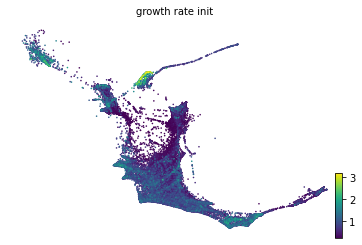

In [17]:
wk.compute_initial_growth_rates(proliferation_key='proliferation', apoptosis_key='apoptosis', 
                                key_added='growth_rate_init')
scv.pl.scatter(adata, c='growth_rate_init', legend_loc='right', basis='force_directed', s=10)

## Compute transition matrix

In computing transport maps between adjacent time-points, WOT incorporates cellular growth and death. The output of the method is a list of transport maps, one for each pair of time points (t_i, t_{i+1}). These are saved in `wk.transport_maps`. Rows in these transport maps do not need to sum to one because depending on whether a cell is likely to proliferate or die, it's outoing probability mass will be larger or smaller than one, respectively. 

CellRank, however, is based on Markov chains where we need one single transition matrix with rows that sum to one. For this reason, in addition to the saved `transport_maps`, we accumulate the individual transport maps into one large transition matrix which we row-normalize. 

Further, for `N` time points, transition probabilities for cells in the Nth time point aren't defined since there is nowhere to transport their probability mass. However, to treat the system as a Markov chain, we need to assign transition probabilites for final-day cells as well. In this example, we'll use transcriptomic similarity for this purpose via the argument `last_time_point='connectivities'`. That means we'll compute transition probabilities for earlier day cells to later day cells using optimal transport, however, once cells have reached the last time-point, we'll compute transition probabilities among final-day cells just based on their gene expression similarity. 

In [18]:
wk.compute_transition_matrix(growth_iters=3, growth_rate_key='growth_rate_init', last_time_point='connectivities')

Computing transition matrix using Waddington optimal transport
Using `1479` HVGs from `adata.var['highly_variable']`
Using default cost matrices
Computing transport maps for `38` time pairs


    Finish (0:03:12)
computing neighbors
    using 'X_pca' with n_pcs = 50


    finished (0:00:00)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
    Finish (0:03:18)


<WOTKernel>

The method argument `growth_iters` defines how many iterations we use to fine-tune the cellular growth rates. For the other parameters, see the original [WOT documentation](link). 

## Gain intuition - simulate random walks

To gain some intuition for the transition matrix we have just computed, we can simualte some random walks and plot them in the embedding. 

Simulating `300` random walks of maximum length `200`


    Finish (0:00:24)


Plotting random walks


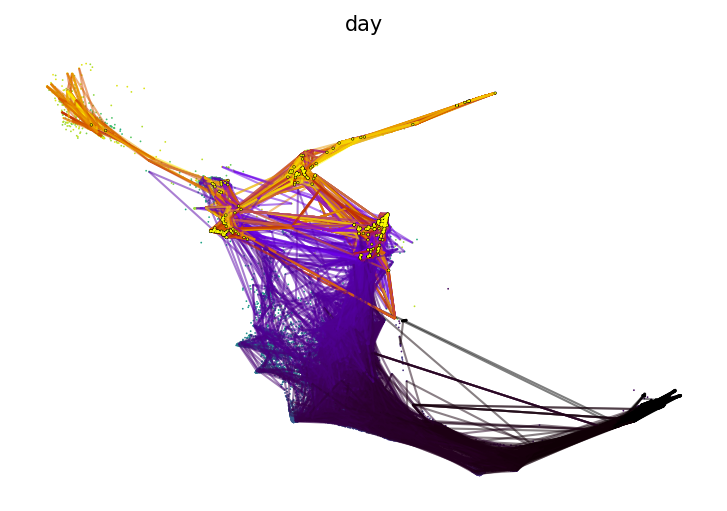

In [19]:
wk.plot_random_walks(n_sims=300, max_iter=200, start_ixs={'day': 0.0}, basis='force_directed', c='day', 
                     legend_loc="none", linealpha=0.5, dpi=150)

Black dots indicate the start of a random walk (can't really see them here, but they come from the lower right corner where day 0 MEFs are located) and yellow dots inicate the end. If we compare with the cluster labels below, we can observe that most random walks terminate in either the Trophoblast, Stromal, Epithelial, Neuronal or IPS clusters. We'll make this more quantitative below using [pyGPCCA](link) to compute macrostates. Generalized Perron Cluster Cluster Analysis (GPCCA) is a fast and mathematically sound way to define macrostates - sets of cells that have some level of metastability. See [Reuter et al, 2019](link) for more information. 

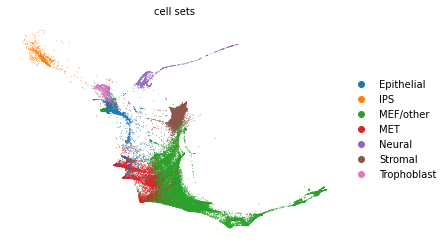

In [20]:
scv.pl.scatter(adata, c='cell_sets', basis='force_directed', legend_loc='right')

## Visualize probability mass flow in time

Based on our transition matrix, we can check how probability mass flows from one cluster to the others as time increases. Note that this plotting function only allows one cluster to have outgoing flow. 

Computing flow from `MEF/other` into `2` cluster(s) in `38` time points
Plotting flow from `MEF/other` into `2` cluster(s) in `38` time points


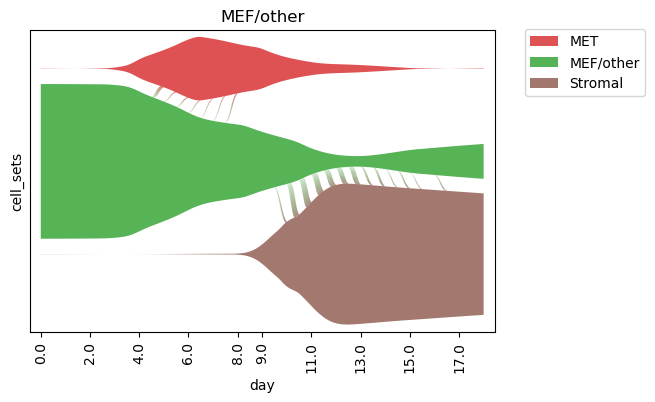

In [21]:
ax = wk.plot_single_flow(cluster_key='cell_sets', 
                         time_key='day', 
                         cluster='MEF/other', 
                         min_flow=0.1, 
                         xticks_step_size=4,
                         show=False, 
                         dpi=100,
                         clusters=['MEF/other', 'MET', 'Stromal'], 
                 )

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks() 
ax.set_xticks(locs)
ax.set_xticklabels(labels, rotation=90)

plt.show()

This plot indicates that MEFs give rise to cells in the mesenchymal-to-epithelial (MET) transition state before populating the stromal state. 

## Compute macrostates

For numerical reasons, we'll add a connectivity kernel with small weight - this makes it much easier and numerically more stable to compute a Schur decomposition, which we need for downstream computations. 

In [22]:
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.estimators import GPCCA

Initialize the connectivity kernel, compute similarity based transition matrix, combine with WOT transition matrix. 

In [23]:
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.9*wk + 0.1*ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Use the combined kernel to initialise a GPCCA estimator. In CellRank, everything that performs inference based on transition matrices is called an `estimator`, see our [kernels and estimators]() tutorial. 

In [24]:
g = GPCCA(combined_kernel)

Compute and plot the Schur decomposition

Computing Schur decomposition
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:49)


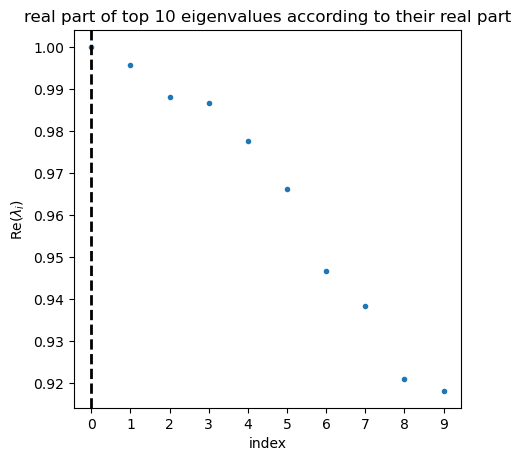

In [25]:
g.compute_schur()
g.plot_spectrum(real_only=True)

Compute 6 macrostates, show the top 30 most confidentially assigned cells per state. 

Computing `6` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:40)


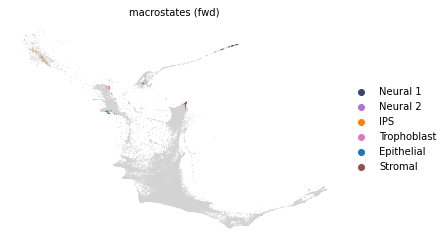

In [26]:
g.compute_macrostates(n_states=6, cluster_key='cell_sets')
g.plot_macrostates(discrete=True, basis='force_directed', legend_loc='right')

## Define terminal macrostates

Write macrostates to AnnData, show how they are coposed in terms of time-points. Keep in mind that we're using the top 30 cells assigned to each macrostate for this analysis. 

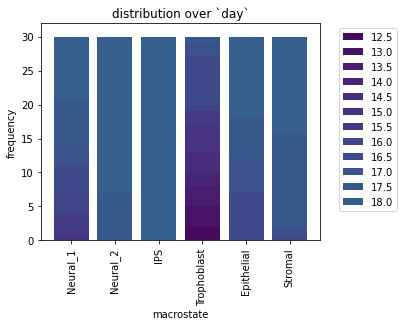

In [42]:
adata.obs['macrostates'] = g.macrostates
adata.uns['macrostates_colors'] = g.macrostates_memberships.colors

stacked_histogram(adata, cat_key='day', rotation=90)

We can see that most macrostates are composed of the later days or reprogramming, i.e. days 16 and later. An exception is the "Trophoblast" state. Below, we're manually selecting some macrostates which we think are terminal states.  

In [28]:
g.set_terminal_states_from_macrostates(['Neural_1', 'IPS', 'Trophoblast', 'Stromal'])

Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


## Compute fate probabilities

Given the terminal states, we can now compute the probability that an early cell will transition towards any of these. 

In [29]:
g.compute_absorption_probabilities(n_jobs=8, solver='gmres', use_petsc=True)

Computing absorption probabilities


Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:07:34)


We can plot the computed fate probabilities in the force-directed embedding. 

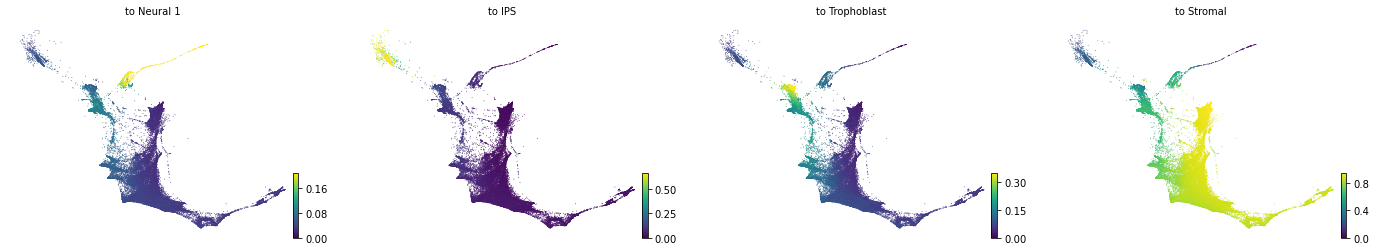

In [32]:
g.plot_absorption_probabilities(same_plot=False, basis='force_directed', perc=[0, 99])

We can summarize fate probabilities towards all terminal states in a circular embedding of the data. 

Solving TSP for `4` states


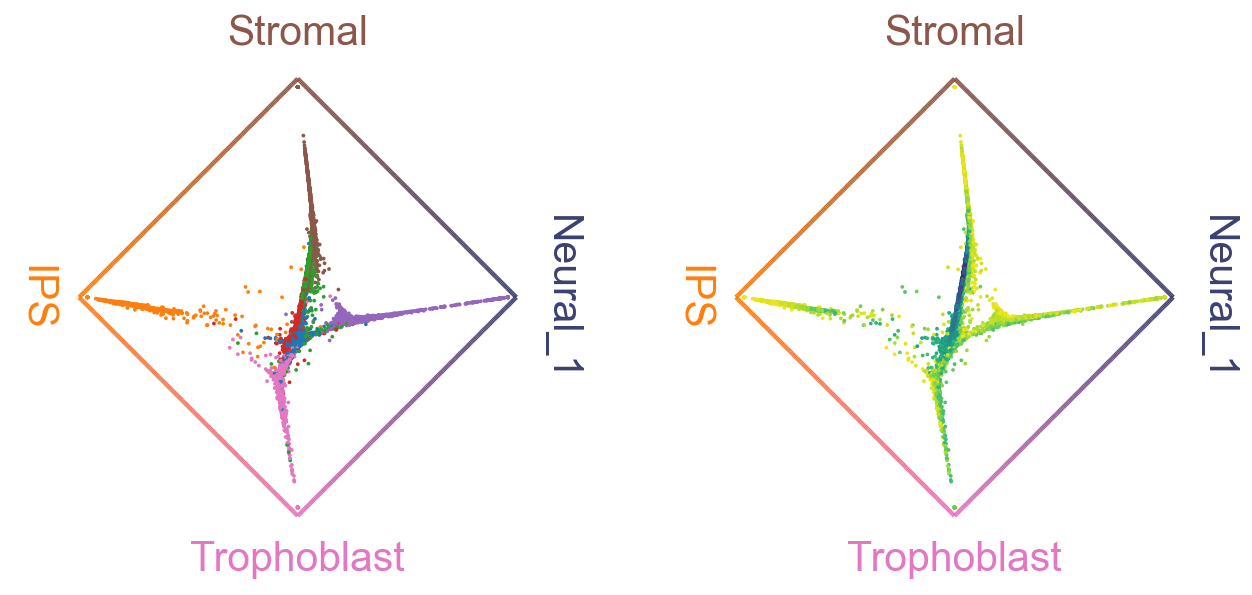

In [48]:
cr.pl.circular_projection(adata, keys=['cell_sets', 'day'], legend_loc="none", title="")

In this representation, uncommited cells are near the center and commited cells are near to one edge. Starting in the MEF cluster (green), cells first decide whether to transition towards Stromal (brown) or MET (red) fates. From the MET cluster, few cells directly transition towards the IPS fate (orange) whether the rest moves towards Trophoblast (pink) of Neural (purple) fates via the Epithelial cluster (blue). 

## Log-odds in time

We can further validate our computed fate probabilities by plotting the distribution of logg-odds for IPS vs. other fates per cell across time-points, coloring in cells that express known lineage-drivers to confirm their upregulation in the expected set of cells. 

Below, we color in Obox6 expression, a TF that was experimentally confirmed to be involved in the reprogramming process in the original publication ([Schiebinger et al., Cell 2019](link))

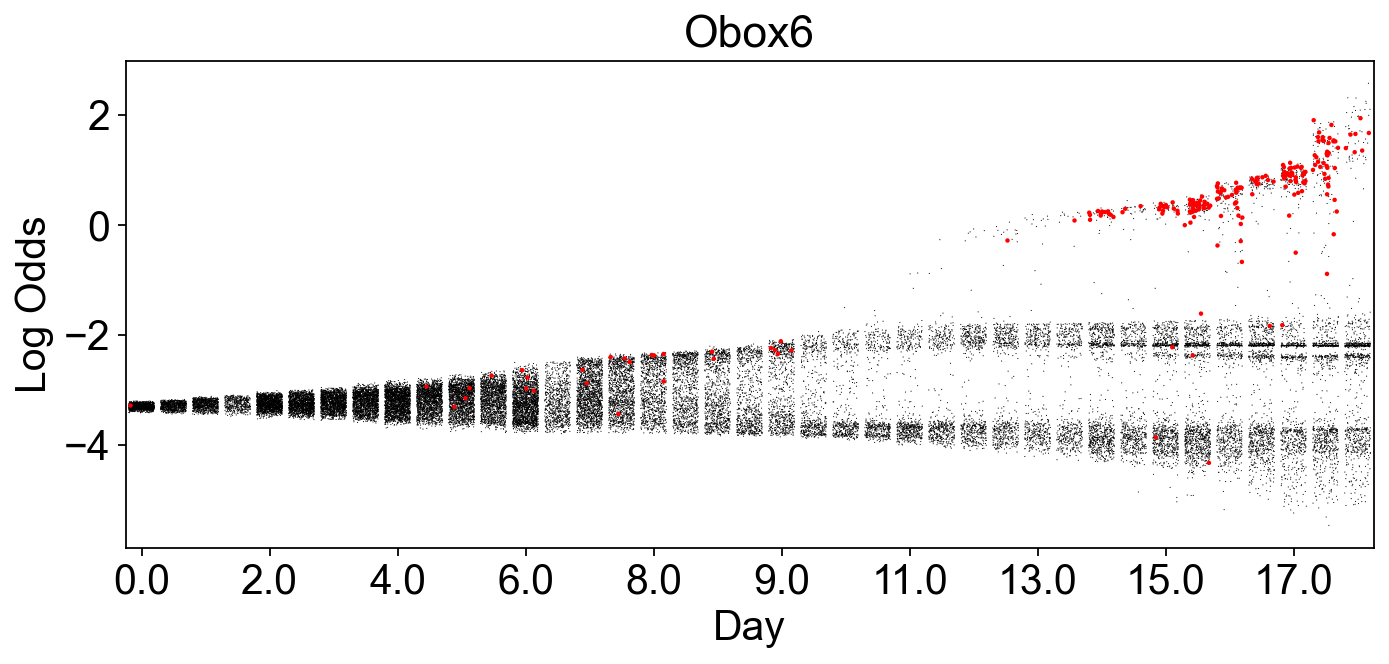

In [57]:
plot_fate(adata, fate='IPS', gene='Obox6', threshold=0, title='Obox6')

We can see that our fate probabilities correctly capture the process of Obox6 upregulation in cells transitioning towards the IPS terminal state. To identify the other branches in this visualization, we will color in ID3 (Stromal fate), Gata3 (Trophoblast fate) and Foxp2 (Neuronal fate). 

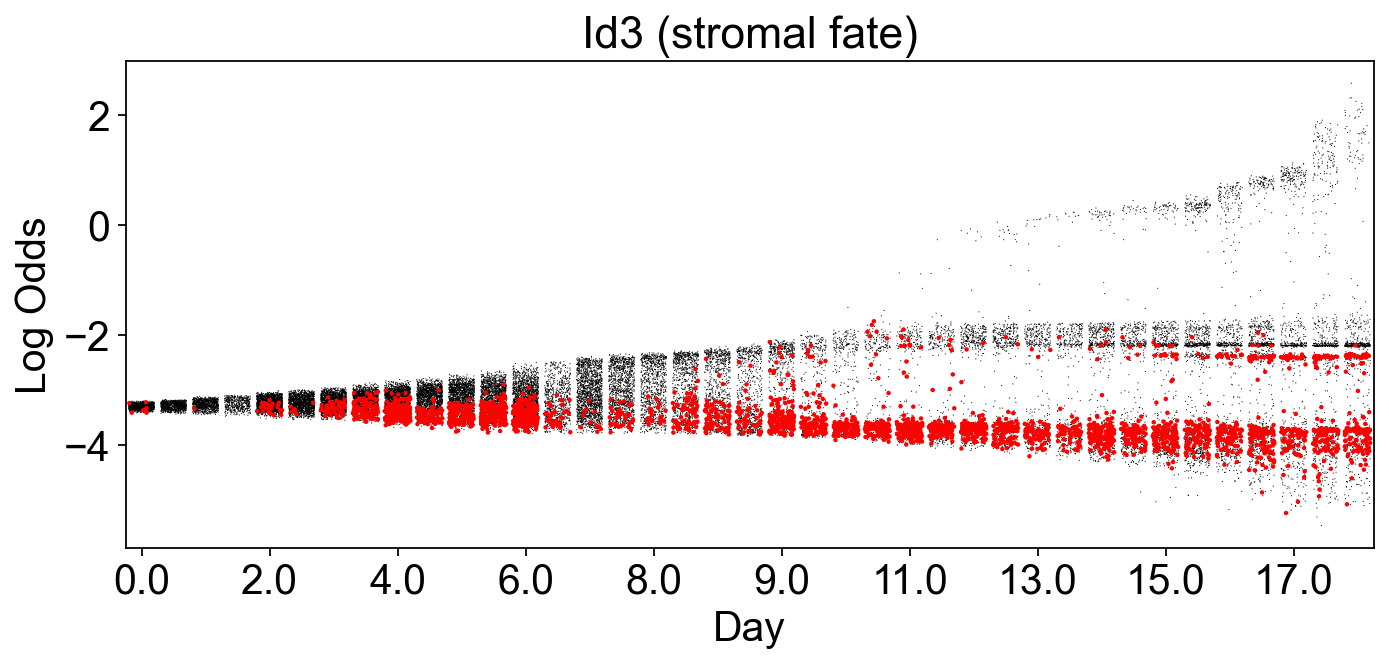

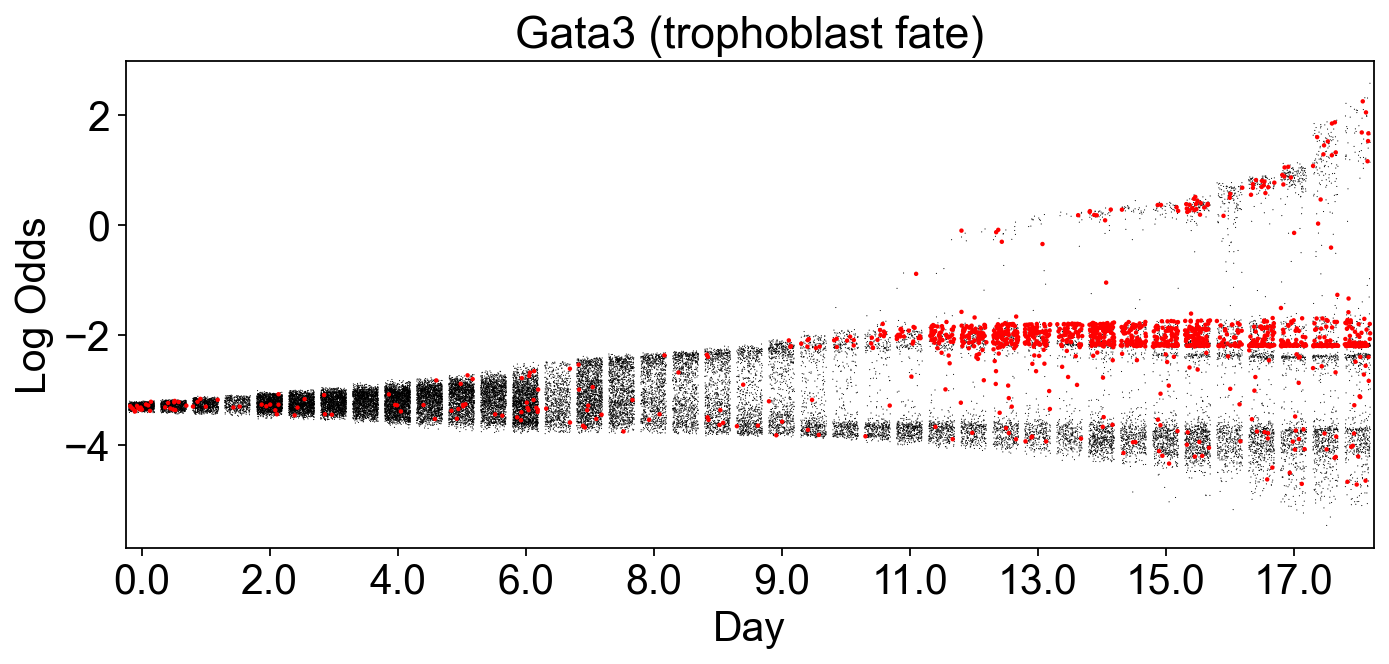

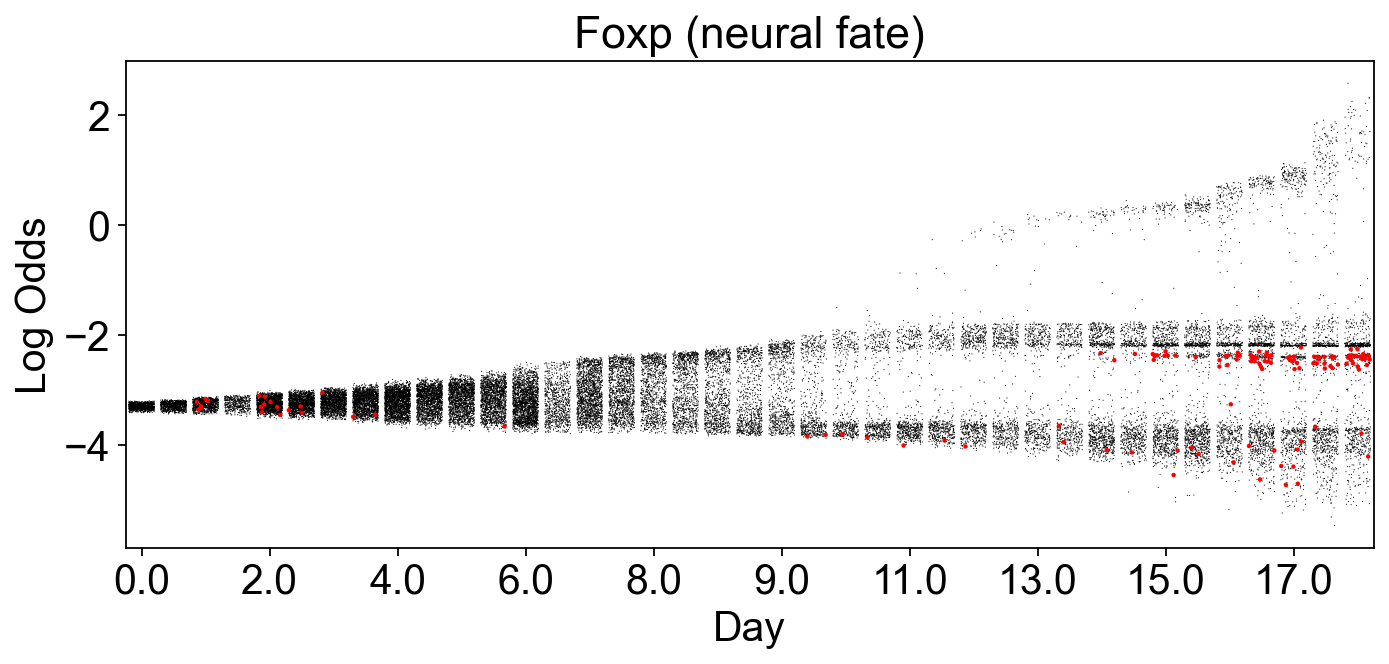

In [62]:
plot_fate(adata, fate='IPS', gene='Id3', threshold=3, title='Id3 (stromal fate)')
plot_fate(adata, fate='IPS', gene='Gata3', threshold=0, title='Gata3 (trophoblast fate)')
plot_fate(adata, fate='IPS', gene='Foxp2', threshold=1, title='Foxp (neural fate)')

## Driver genes

Compute driver genes by correlating with fate probabilities. 

In [89]:
g.compute_lineage_drivers(return_drivers=False)

Computing correlations for lineages `['Neural_1' 'IPS' 'Trophoblast' 'Stromal']` restricted to clusters `None` in layer `X` with `use_raw=False`
Adding `.lineage_drivers`
       `adata.var['to Neural_1 corr']`
       `adata.var['to IPS corr']`
       `adata.var['to Trophoblast corr']`
       `adata.var['to Stromal corr']`
    Finish (0:00:06)


We'll look at the trophoblast vs. neural lineages here and plot their fate correlations in a scatter plot. We'll annotate some genes that have been found to be lineage-correlated in the original publication. 

In [105]:
trophoblast_genes = ['Gata3', 'Elf5', 'Ascl2', 'Phlda2', 'Rhox6', 
                     'Rhox9', 'Batf3', 'Elf3']
neural_genes = [  'Pou3f2', 'Nr2f1', 'Myt1l', 'Scrt2', 'Nhlh2', 'Pou2f2']
stromal_genes = ['Id3', 'Nfix', 'Nfic', 'Prrx1']

genes_oi = trophoblast_genes + neural_genes + stromal_genes

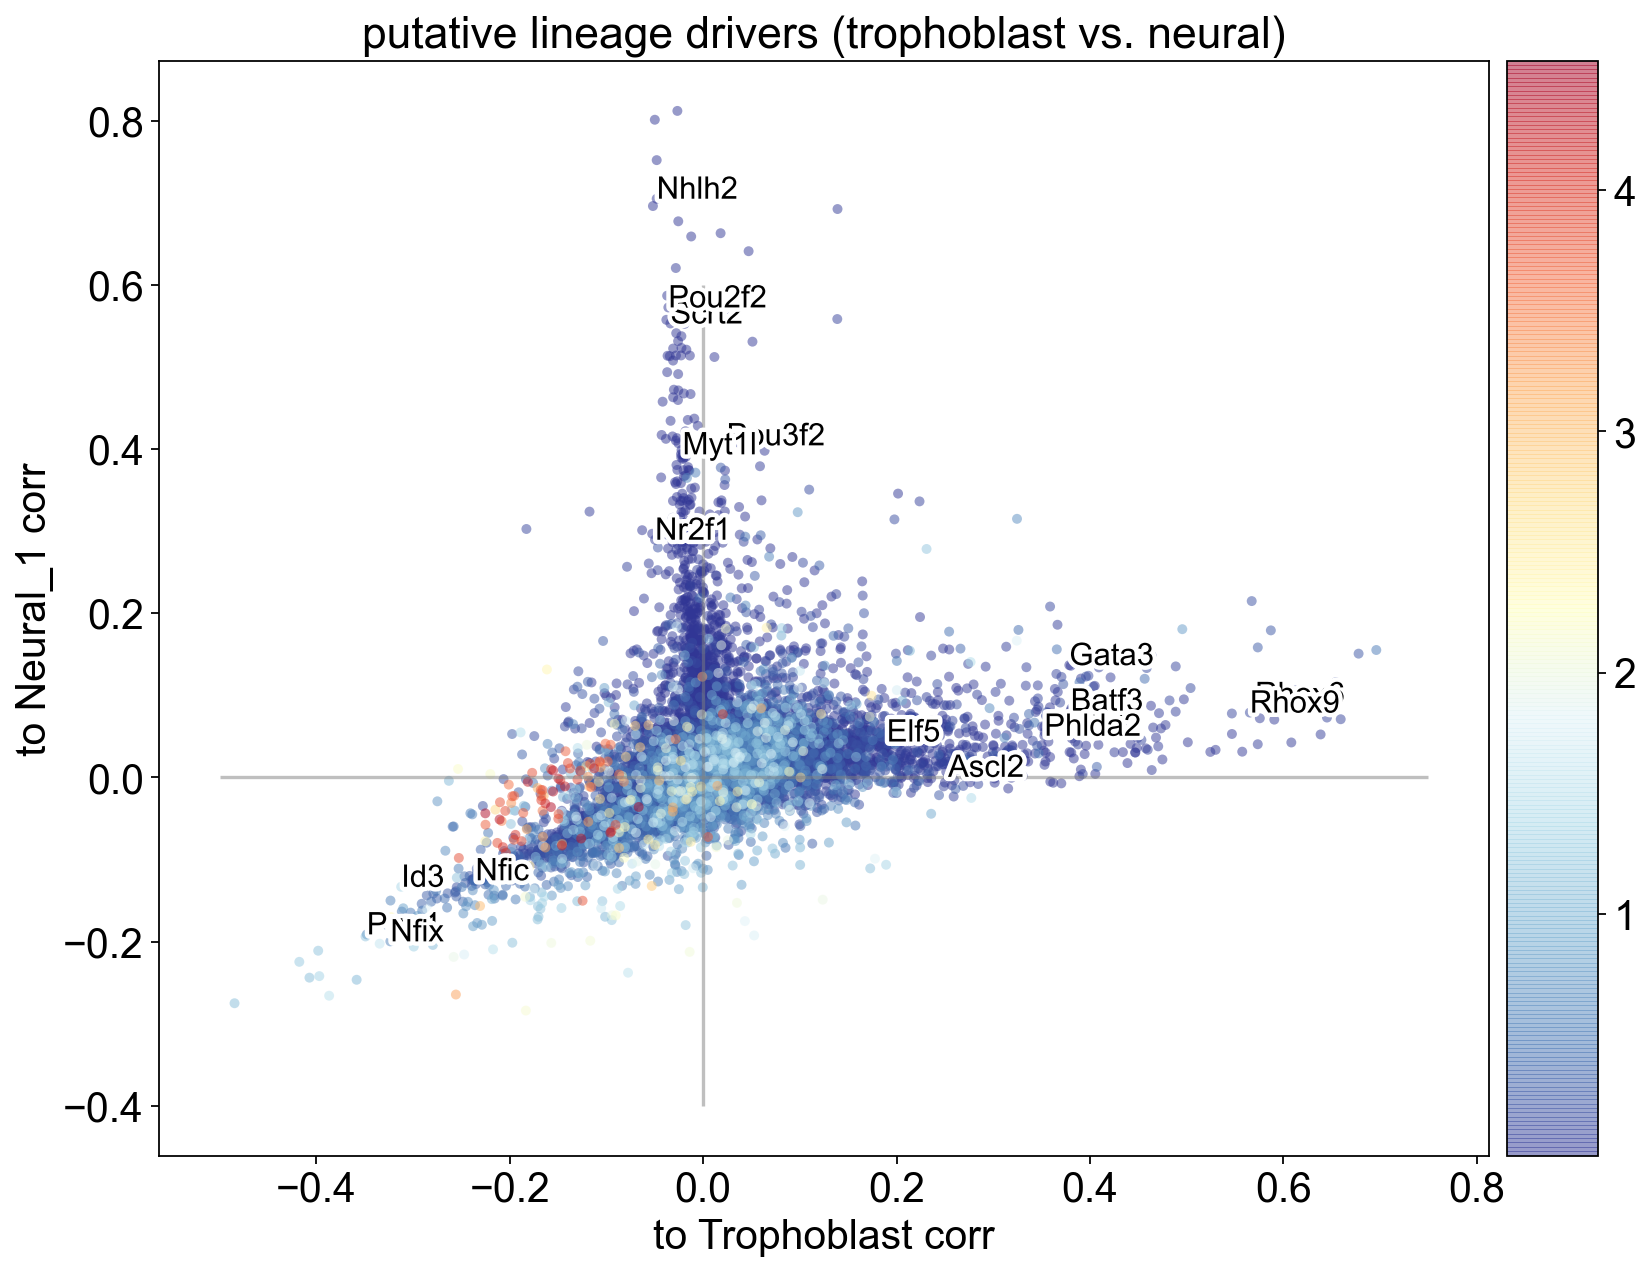

In [107]:
adata.var['means'] = np.mean(adata.X.A, 0)

rcParams['figure.figsize'] = (9, 9)

lin_1 = 'to Trophoblast corr'
lin_2 = 'to Neural_1 corr'

ax = sc.pl.scatter(adata, size=80, color_map='RdYlBu_r', alpha=0.5, color='means',
              x = lin_1,
              y = lin_2,
             show=False, title='putative lineage drivers (trophoblast vs. neural)')

ax.vlines(0,ymin = -0.4, ymax=0.6, color='grey', alpha=0.5)
ax.hlines(0, xmin = -0.5, xmax=0.75, color='grey', alpha=0.5)

# Label names and positions,
x = [i for i in adata.var[lin_1]]
y = [i for i in adata.var[lin_2]]
labels = adata.var_names

# Show only some labels to avoid overcrowding the figure,
to_remove = np.where(np.invert(np.in1d(adata.var_names, genes_oi)))[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

path_effect = [patheffects.withStroke(linewidth=4, foreground='w',)]

for i,txt in enumerate(labels):
    ax.annotate(txt, xy=(x[i], y[i]), color='black', path_effects=path_effect, size=14) 

plt.show()

We should annotate these in difference colors, so that it's more convincing. 